<a href="https://colab.research.google.com/github/maxreynolds/Pattern-Cloud/blob/main/Pattern_TextualInversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pattern Fine-tuning Workflow

This Notebook is an example of the workflow that Pattern is initially supporting. To train stable diffusion on our user's images, we'll use fine-tuning, which involves taking a pre-trained stable diffusion model and training it further on a new dataset. In this way, we can leverage the knowledge already learned by the pre-trained model and adapt it to the new dataset, allowing us to achieve better performance with less training time.

In [ ]:
!nvidia-smi

Fri Nov 10 19:17:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    49W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!cd /content/
!pip install -q streamlit
!git clone https://github.com/huggingface/diffusers.git
!pip install ./diffusers
!pip install -U -r /content/diffusers/examples/textual_inversion/requirements.txt
!pip install wandb
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
!nohup /content/cloudflared-linux-amd64 tunnel --url http://localhost:8501 &

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 112.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.5 MB/s eta 0:00:00
Cloning into 'diffusers'...
remote: Enumerating objects: 46934, done.
remote: Counting objects: 100% (4000/4000), done.
remote: Compressing objects: 100% (1285/1285), done.
remote: Total 46934 (delta 2901), reused 3366 (delta 2376), pack-reused 42934
Receiving objects: 100% (46934/46934), 29.55 MiB | 16.42 MiB/s, done.
Resolving deltas: 100% (34742/34742), done.
Processing ./diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 5.6 MB/s eta

In [2]:
!mkdir /content/user_images
!ls

cloudflared-linux-amd64  diffusers  nohup.out  sample_data  user_images


In [3]:
!grep -o 'https://.*\.trycloudflare.com' nohup.out | head -n 1 | xargs -I {} echo "Your tunnel url {}"

Your tunnel url https://prozac-yesterday-peter-circle.trycloudflare.com


In [6]:
!streamlit run /content/app.py &>/content/logs.txt &

In [5]:
%%writefile app.py
from diffusers import StableDiffusionPipeline

import streamlit as st
import torch

from PIL import Image
import csv
import os


def delete_files_in_directory(directory_path):
   try:
     files = os.listdir(directory_path)
     for file in files:
       file_path = os.path.join(directory_path, file)
       if os.path.isfile(file_path):
         os.remove(file_path)
   except OSError:
     print("Error occurred while deleting files.")

image_set = []
image_set = st.file_uploader("Upload a folder of your training dataset Images:",
    type=["png"], accept_multiple_files=True) # TODO: expand to type=["png","jpg","jpeg"]]... need to update metadata.csv writer code to check for filetype

if image_set is not None:
    #st.write('Scroll down for next steps')
    st.image(image_set, width=128)

if st.button('Upload Images to Colab Notebook', type="primary", use_container_width=True):
    placeholder = st.empty()
    placeholder.text("Formatting images...")
    for idx, image in enumerate(image_set):
      im = Image.open(image)
      im.save(f"/content/user_images/image{idx}.png")
    num_images = len(image_set)
    placeholder.text('Upload complete!')
    #removing image files here
    #delete_files_in_directory('/content/user_images')

Writing app.py


In [7]:
!accelerate config default --mixed_precision fp16

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


Time to configure our environment variables. For this, we want to tell the script our model name, dataset name, and where we would like it to output the model. We will be automatically pushing the model directly to HuggingFace Hub which will require us to login to our HuggingFace account using the token provided through your HuggingFace account settings.

In [8]:
import os

os.environ['MODEL_NAME'] = f'runwayml/stable-diffusion-v1-5'

os.environ['DATASET_NAME'] = f'MaxReynolds/Lee_Souder_Combined'
os.environ['OUTPUT_DIR'] = f'SouderRocketLauncherNetCombined-inversion-style'
os.environ['DATA_DIR'] = f'/content/user_images'


In [9]:
from huggingface_hub import notebook_login
notebook_login()

In [10]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [14]:
!ls user_images

image0.png   image15.png  image20.png  image26.png  image31.png  image37.png  image8.png
image10.png  image16.png  image21.png  image27.png  image32.png  image3.png   image9.png
image11.png  image17.png  image22.png  image28.png  image33.png  image4.png
image12.png  image18.png  image23.png  image29.png  image34.png  image5.png
image13.png  image19.png  image24.png  image2.png   image35.png  image6.png
image14.png  image1.png   image25.png  image30.png  image36.png  image7.png


In [15]:
!accelerate launch diffusers/examples/textual_inversion/textual_inversion.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --train_data_dir=$DATA_DIR \
  --learnable_property="style" \
  --placeholder_token="<lee-souder>" --initializer_token="Halo" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=3000 \
  --learning_rate=5.0e-04 --scale_lr \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --output_dir="textual_inversion_gunstyle" \
  --push_to_hub \
  --report_to="wandb" \
  --validation_prompt="A Rocket Launcher in the style of <lee-souder> " \
  --num_validation_images=4 \
  --validation_steps=100


Streaming output truncated to the last 5000 lines.
diffusion_pytorch_model.safetensors:  30% 1.04G/3.44G [01:41<03:03, 13.1MB/s]





model.safetensors:  83% 1.01G/1.22G [01:49<00:23, 8.72MB/s]




diffusion_pytorch_model.safetensors:  30% 1.04G/3.44G [01:41<03:19, 12.0MB/s]





model.safetensors:  83% 1.01G/1.22G [01:50<00:18, 11.0MB/s]




diffusion_pytorch_model.safetensors:  30% 1.04G/3.44G [01:41<04:17, 9.30MB/s]





model.safetensors:  83% 1.01G/1.22G [01:50<00:19, 10.3MB/s]




diffusion_pytorch_model.safetensors:  30% 1.04G/3.44G [01:42<03:37, 11.0MB/s]





model.safetensors:  84% 1.02G/1.22G [01:50<00:17, 11.6MB/s]




diffusion_pytorch_model.safetensors:  30% 1.05G/3.44G [01:42<03:20, 12.0MB/s]





model.safetensors:  84% 1.02G/1.22G [01:50<00:15, 12.6MB/s]




diffusion_pytorch_model.safetensors:  31% 1.05G/3.44G [01:42<03:33, 11.2MB/s]





model.safetensors:  84% 1.02G/1.22G [01:51<00:16, 11.5MB/s]




diffusion_pytorch_model.safetensors:  31% 1.05G/3.44G [01:42<03:13,

In [17]:
!ls

app.py			 diffusers  nohup.out	 textual_inversion_gunstyle  wandb
cloudflared-linux-amd64  logs.txt   sample_data  user_images


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

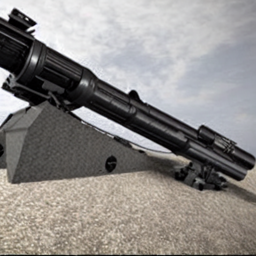

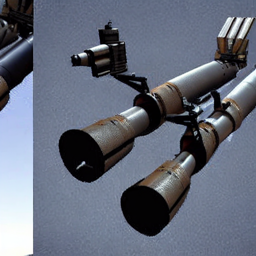

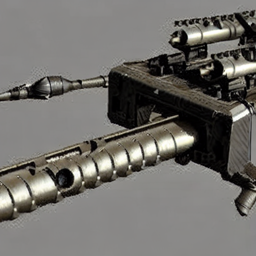

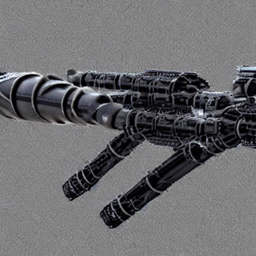

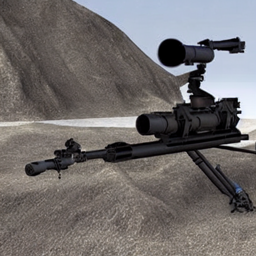

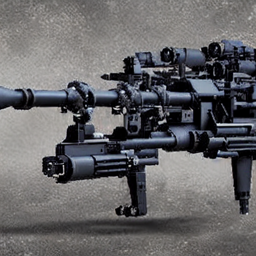

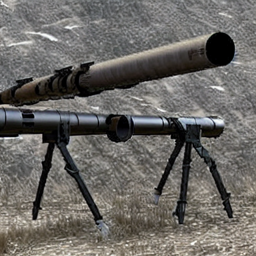

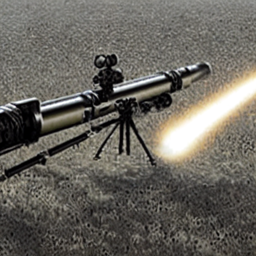

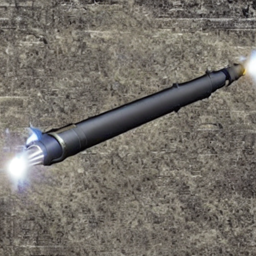

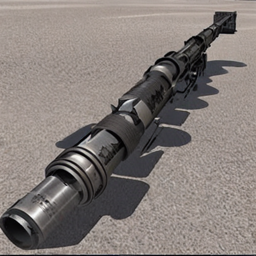

In [20]:
# Now let's Run inference on our new model

from diffusers import StableDiffusionPipeline
import torch
from PIL import Image

# Setting model path to the model we just trained
model_path = './textual_inversion_gunstyle'

#load the model
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16)
pipe.to("cuda")

my_prompt = "A rocket launcher in the style of <lee-souder>"
num_images = 10

# Run inference using above prompt to acquire some number of images
all_images = [pipe(prompt=my_prompt).images[0] for i in range(num_images)]
for idx, image in enumerate(all_images):
  image = image.resize((256, 256))
  image.save(f"image{idx}.png")
  display(image)
